In [1]:
train_VAE = False
train_GAN = False
train_NF  = False

In [2]:
import numpy as np
import pandas as pd

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [4]:
import models

In [5]:
import os
os.makedirs("./saved_models/", exist_ok=True)

In [6]:
seed = 1337

In [7]:
torch.manual_seed(seed)
import random
random.seed(seed)
np.random.seed(seed)

In [8]:
data = np.loadtxt("data/events_smear.txt")

# Delete Energy (E) entries
# data = np.delete(data, [0, 4], axis=1)

# Delete theta and phi
data = np.delete(data, [8, 9], axis=1)
input_dimension = data.shape[1]

In [9]:
data.mean(), data.std()

(24.998955315003283, 66.23548685106118)

In [10]:
run_name = f"-smeared-final-{seed}"

In [11]:
data.shape

(100000, 8)

In [12]:
def loss_plot(losses, name):
    plt.plot(losses)
    plt.title(f"{name} model loss during training")
    plt.xlabel('Train Step')
    plt.ylabel('Loss')
    plt.show()

In [13]:
latent_dim = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = models.VAE(input_dimension, latent_dim, device=device).to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) 


In [14]:
print(device, vae_optimizer.defaults)

cpu {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(vae)

688336

In [16]:
def fix_losses(losses):
    return np.array(list(map(lambda x : x.detach().numpy(), losses)))

In [17]:
class PCDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        if self.transform:
            item = self.transform(item)
        return item

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
X_train, X_test = train_test_split(data, test_size=0.15, random_state=seed)
preprocessor = StandardScaler(with_mean=True, with_std=True)
# preprocessor = MinMaxScaler((-1, 1))
# preprocessor = MinMaxScaler()
# preprocessor = MaxAbsScaler()
scaler = preprocessor.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
print(X_train.mean(), X_train.std())
print(X_test.mean(), X_test.std())

-5.406524574441358e-14 1.0
-0.0008868384957880099 1.0010710715246876


In [20]:
train_dataset = PCDataset(X_train)
val_dataset = PCDataset(X_test)

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(val_dataset, shuffle=True)

In [22]:
import time

In [23]:
vae_losses = []
vae_kl_losses = []
vae_rc_losses = []

def train_VAE_helper(epochs):
    vae.train()
    time_total = 0

    for i in range(epochs):

        start_time = time.time()

        vae_loss_avg, recon_loss_avg, KL_loss_avg = 0, 0, 0

        for batch in train_dataloader:

            vae_loss, recon_loss, KL_loss = vae.loss_function(batch.float().to(device))

            vae_losses.append(vae_loss)
            vae_kl_losses.append(KL_loss)
            vae_rc_losses.append(recon_loss)

            vae_loss_avg += vae_loss.detach().cpu().numpy() / len(train_dataloader)
            recon_loss_avg += recon_loss.detach().cpu().numpy() / len(train_dataloader)
            KL_loss_avg += KL_loss.detach().cpu().numpy() / len(train_dataloader)

            vae_optimizer.zero_grad()
            vae_loss.backward()
            vae_optimizer.step()
        time_total += (time.time() - start_time)
        print("Epoch:", i+1, f"time passed: {time.time() - start_time:.2f}s", f"Train Losses (avg.): vae={vae_loss_avg:.5f}, recon={recon_loss_avg:.5f}, kl={KL_loss_avg:.5f}")
    print(f"Total time for {epochs} epochs: {time_total}")
    plt.plot(fix_losses(vae_losses), label="Total")
    plt.plot(fix_losses(vae_kl_losses), label="KL")
    plt.plot(fix_losses(vae_rc_losses), label="Recon")
    plt.title("VAE model loss during training")
    plt.xlabel('Train Step')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()

In [24]:
epochs = 25
filename = f"./saved_models/vae-{epochs}e" + run_name

if train_VAE:
    vae.train()
    train_VAE_helper(epochs)
    torch.save(vae.state_dict(), filename)
else:
    vae.load_state_dict(torch.load(filename))
    vae.eval()

In [25]:
dummy_data = torch.Tensor(torch.normal(0, 1, size=(15_000, latent_dim)))
vae.eval()
vae_x_hat = vae.decode(dummy_data).detach()
VAE_generated = scaler.inverse_transform(vae_x_hat)

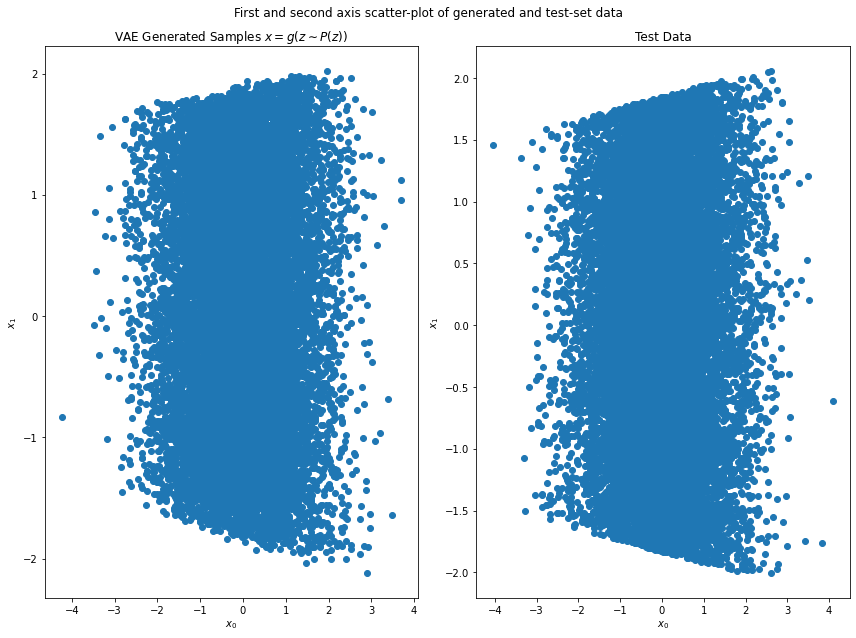

In [26]:
fig, axs = plt.subplots(1,2, figsize=(12,9))
fig.suptitle("First and second axis scatter-plot of generated and test-set data")
axs[0].scatter(vae_x_hat[:, 0], vae_x_hat[:, 1])
axs[0].set_title(r"VAE Generated Samples $x = g(z \sim P(z))$")
axs[0].set_xlabel(r"$x_0$")
axs[0].set_ylabel(r"$x_1$")
# plt.show()

axs[1].scatter(X_test[:, 0], X_test[:, 1])
axs[1].set_title("Test Data")
axs[1].set_xlabel(r"$x_0$")
axs[1].set_ylabel(r"$x_1$")
plt.tight_layout()
plt.show()

In [27]:
gan = models.GAN(input_shape = input_dimension)

In [28]:
count_parameters(gan), count_parameters(gan.discriminator), count_parameters(gan.generator)

(850825, 136193, 714632)

In [29]:
d_losses = []
g_losses = []

def train_GAN_helper(epochs):
    time_total = 0
    for i in range(epochs):

        start_time = time.time()

        d_loss_avg, g_loss_avg = 0, 0

        for batch in train_dataloader:

            d_loss, g_loss = gan.train_with_batch(batch.float().to(device))

            d_losses.append(d_loss)
            g_losses.append(g_loss)

            d_loss_avg += d_loss / len(train_dataloader)
            g_loss_avg += g_loss / len(train_dataloader)

        time_total += (time.time() - start_time)
        print("Epoch:", i+1, f"time passed: {time.time() - start_time:.2f}s", f"Train Losses (avg.): discriminator={d_loss_avg:.5f}, generator={g_loss_avg:.5f}")
    print(f"Total time for {epochs} epochs: {time_total}")
    plt.plot(d_losses, label="Discriminator")
    plt.plot(g_losses, label="Generator")
    plt.title(f"GAN model losses during training")
    plt.xlabel('Train Step')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()

In [30]:
epochs = 25
filename =  f"./saved_models/gan-{epochs}e" + run_name

if train_GAN:
    gan.train()
    train_GAN_helper(epochs)
    torch.save(gan.state_dict(), filename)
else:
    gan.load_state_dict(torch.load(filename))
    gan.eval()

In [31]:
gan.eval()
gan_x_hat = gan.generate(15_000).detach()
GAN_generated = scaler.inverse_transform(gan_x_hat)

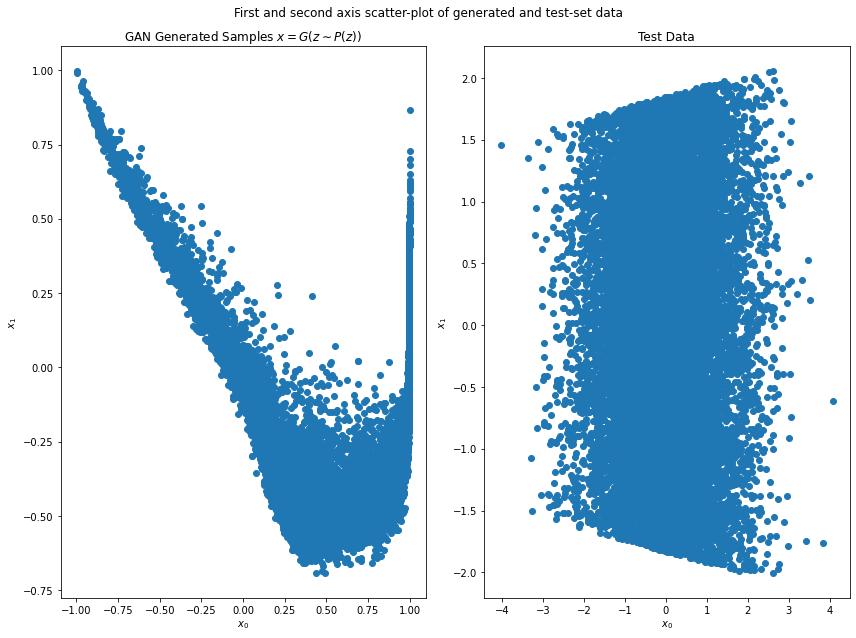

In [32]:
fig, axs = plt.subplots(1,2, figsize=(12,9))
fig.suptitle("First and second axis scatter-plot of generated and test-set data")
axs[0].scatter(gan_x_hat[:, 0], gan_x_hat[:, 1])
axs[0].set_title(r"GAN Generated Samples $x = G(z \sim P(z))$")
axs[0].set_xlabel(r"$x_0$")
axs[0].set_ylabel(r"$x_1$")
# plt.show()

axs[1].scatter(X_test[:, 0], X_test[:, 1])
axs[1].set_title("Test Data")
axs[1].set_xlabel(r"$x_0$")
axs[1].set_ylabel(r"$x_1$")
plt.tight_layout()
plt.show()

In [33]:
pd.DataFrame(GAN_generated).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,102.912006,-12.076900,6.441564,65.870302,102.129566,1.993639,-6.623223,-67.585192
std,2.213856,15.431447,44.570689,15.801405,2.747241,18.356765,43.335615,12.857498
min,95.019993,-38.120810,-52.399617,-12.818513,95.014516,-53.775639,-56.764672,-89.113233
25%,101.576683,-23.888259,-43.764705,60.608681,99.894258,-9.101887,-53.067913,-74.714224
50%,103.524769,-14.822839,13.519350,65.850187,102.714832,5.950392,-12.178223,-69.103175
75%,104.921555,-4.370547,53.989166,77.856526,104.864038,16.768742,41.621638,-63.229040
max,105.001862,53.607294,56.764717,89.375869,105.001859,33.092052,52.386261,12.662927


In [34]:
pd.DataFrame(VAE_generated).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,99.901591,1.912417,4.065483,43.899680,99.885602,-1.799346,-4.066407,-43.826237
std,4.985558,53.143254,53.350939,45.375474,4.985309,53.162032,53.299526,45.338711
min,78.808399,-115.628218,-115.177789,-107.565307,78.689684,-109.495091,-117.363978,-116.091398
25%,96.418742,-41.605616,-40.283798,16.575394,96.416504,-45.591426,-47.964971,-79.306032
50%,99.916746,0.744187,5.464801,54.960733,99.886921,-0.693917,-5.517054,-54.982198
75%,103.388460,45.670241,48.000921,79.536249,103.387852,41.696832,40.305198,-16.548330
max,118.500378,109.171970,115.678649,116.634221,118.379492,112.980136,115.817531,107.563826


In [35]:
pd.DataFrame(scaler.inverse_transform(X_test)).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,99.980735,-0.560955,2.061706,37.553927,99.980735,0.560955,-2.061706,-37.553927
std,4.988104,54.327124,54.828025,51.470275,4.988104,54.327124,54.828025,51.470275
min,79.788397,-109.437808,-115.176656,-113.555643,79.788397,-111.054616,-112.050080,-113.744361
25%,96.659401,-44.701308,-43.834721,8.429329,96.659401,-44.254824,-46.618627,-78.844261
50%,99.970282,-0.907680,5.244990,51.163805,99.970282,0.907680,-5.244990,-51.163805
75%,103.378702,44.254824,46.618627,78.844261,103.378702,44.701308,43.834721,-8.429329
max,120.430790,111.054616,112.050080,113.744361,120.430790,109.437808,115.176656,113.555643


In [36]:
pd.DataFrame(scaler.inverse_transform(np.random.normal(0, 1, size=(15_000, 8)))).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,100.039439,-1.304311,1.803425,38.396520,100.015242,0.931808,-1.551203,-37.625897
std,5.006802,54.184838,54.376793,51.308264,4.977471,54.406314,54.042220,51.084888
min,78.340455,-218.520785,-255.519431,-156.466595,81.300384,-219.344238,-204.953415,-251.730041
25%,96.658656,-37.943271,-35.014541,3.465763,96.615747,-35.998456,-37.720431,-71.631633
50%,99.983564,-1.359853,2.280508,38.698310,100.025212,0.780883,-2.191921,-37.408270
75%,103.435824,36.123626,38.693852,73.805318,103.383701,37.940525,34.658539,-3.529117
max,119.767823,218.685518,217.012620,241.781507,120.042818,226.956441,221.929977,153.206641


In [37]:
# https://gebob19.github.io/normalizing-flows/
d = input_dimension
k = input_dimension // 2
print(d, k)
NF_model = models.stacked_NVP(d, k, hidden=512, n=3)
single_NF_model = models.R_NVP(d, k, hidden=512)
# NF_model = single_NF_model
NF_optim = torch.optim.Adam(NF_model.parameters(), lr=1e-3)
nf_scheduler = torch.optim.lr_scheduler.ExponentialLR(NF_optim, 0.999)
n_samples = 512

8 4


In [38]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7
count,8.500000e+04,8.500000e+04,8.500000e+04,8.500000e+04,8.500000e+04,8.500000e+04,8.500000e+04,8.500000e+04
mean,-2.162592e-13,1.172813e-16,-3.173200e-16,2.709676e-15,-2.162592e-13,-1.172813e-16,3.173200e-16,-2.709676e-15
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-4.216736e+00,-2.099263e+00,-2.181867e+00,-3.066225e+00,-4.216736e+00,-2.124708e+00,-2.113669e+00,-1.574320e+00
25%,-6.762098e-01,-8.222591e-01,-8.304133e-01,-5.706101e-01,-6.762098e-01,-8.166101e-01,-8.160982e-01,-8.021437e-01
50%,-1.798131e-03,-1.906122e-03,6.369738e-02,2.691991e-01,-1.798131e-03,1.906122e-03,-6.369738e-02,-2.691991e-01
75%,6.727124e-01,8.166101e-01,8.160982e-01,8.021437e-01,6.727124e-01,8.222591e-01,8.304133e-01,5.706101e-01
max,4.650007e+00,2.124708e+00,2.113669e+00,1.574320e+00,4.650007e+00,2.099263e+00,2.181867e+00,3.066225e+00


In [39]:
def train_NF_helper(model, epochs, optim, scheduler):
    losses = []
    eval_losses = []
    torch.autograd.set_detect_anomaly(False)
    time_total = 0
    for i in range(epochs):
        start_time = time.time()
        loss_avg = 0
        model.train()
        # get batch 
        for batch in train_dataloader:
            optim.zero_grad()
            z, log_pz, log_jacob = model(batch.float().to(device))
            loss = (-log_pz - log_jacob).mean()
            losses.append(loss)
            loss_avg += (loss / len(train_dataloader))
            loss.backward()
            optim.step()
            scheduler.step()
        time_total += (time.time() - start_time)
        print("Epoch:", i+1, f"time passed: {time.time() - start_time:.2f}s", f"Train Losses (avg.): {loss_avg:.5f}")

    print(f"Total time for {epochs} epochs: {time_total}")
    return losses

In [40]:
epochs = 25
filename =  f"./saved_models/3-stacked_nf-{epochs}e" + run_name
losses = []

if train_NF:
    NF_model.train()
    losses = train_NF_helper(NF_model, epochs, NF_optim, nf_scheduler)
    torch.save(NF_model.state_dict(), filename)
else:
    NF_model.load_state_dict(torch.load(filename))
    NF_model.eval()

In [41]:
count_parameters(NF_model)

27672

In [42]:
def view(model, losses):
    loss_plot(losses, "NF")
    Z = single_NF_model.base_dist.rsample(sample_shape=(15000,))
    X_hat = model.inverse(Z).detach().numpy()
    return X_hat

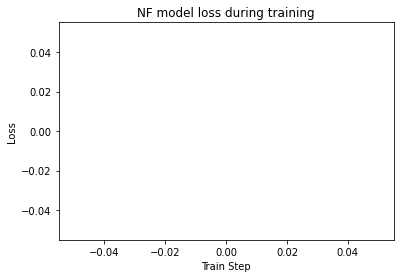

In [43]:
NF_generated = view(NF_model, fix_losses(losses))

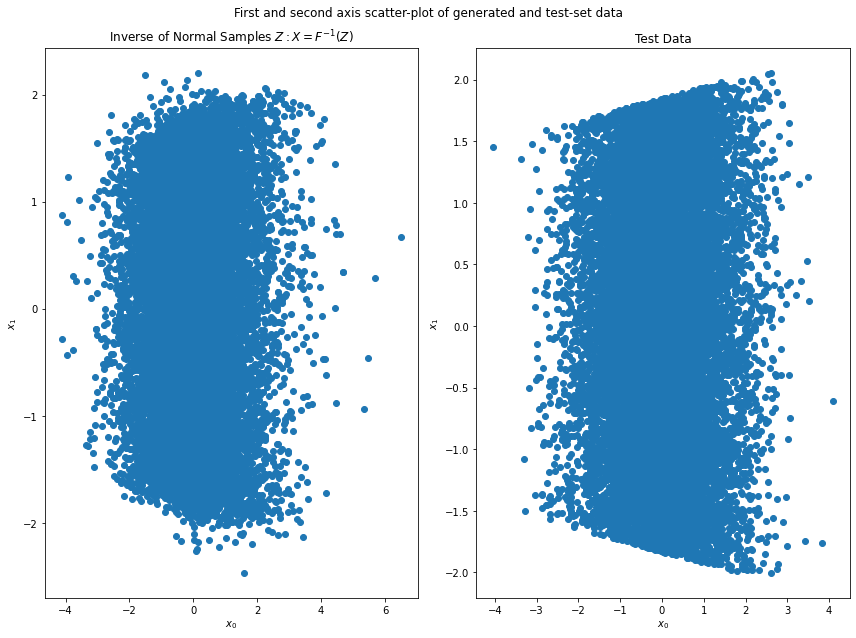

In [44]:
fig, axs = plt.subplots(1,2, figsize=(12,9))
fig.suptitle("First and second axis scatter-plot of generated and test-set data")
axs[0].scatter(NF_generated[:, 0], NF_generated[:, 1])
axs[0].set_title(r"Inverse of Normal Samples $Z: X = F^{-1}(Z)$")
axs[0].set_xlabel(r"$x_0$")
axs[0].set_ylabel(r"$x_1$")
# plt.show()

axs[1].scatter(X_test[:, 0], X_test[:, 1])
axs[1].set_title("Test Data")
axs[1].set_xlabel(r"$x_0$")
axs[1].set_ylabel(r"$x_1$")
plt.tight_layout()
plt.show()

In [45]:
pd.DataFrame(VAE_generated).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,99.901591,1.912417,4.065483,43.899680,99.885602,-1.799346,-4.066407,-43.826237
std,4.985558,53.143254,53.350939,45.375474,4.985309,53.162032,53.299526,45.338711
min,78.808399,-115.628218,-115.177789,-107.565307,78.689684,-109.495091,-117.363978,-116.091398
25%,96.418742,-41.605616,-40.283798,16.575394,96.416504,-45.591426,-47.964971,-79.306032
50%,99.916746,0.744187,5.464801,54.960733,99.886921,-0.693917,-5.517054,-54.982198
75%,103.388460,45.670241,48.000921,79.536249,103.387852,41.696832,40.305198,-16.548330
max,118.500378,109.171970,115.678649,116.634221,118.379492,112.980136,115.817531,107.563826


In [46]:
pd.DataFrame(scaler.inverse_transform(NF_generated)).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,100.165749,-0.603896,1.705284,36.846043,100.196968,0.501350,-1.985280,-36.185547
std,5.475952,54.469540,54.162033,51.069431,5.532614,55.246555,54.650677,51.228161
min,79.391815,-134.502625,-190.300720,-131.986252,79.198448,-112.665268,-125.622864,-122.376396
25%,96.506611,-44.973068,-42.139119,7.136017,96.494524,-45.186294,-46.125329,-77.221619
50%,99.983887,-0.485750,1.795799,49.021935,100.003799,0.489490,-2.173385,-49.166471
75%,103.589573,44.293176,44.906098,76.836864,103.638653,46.175948,42.584946,-6.063520
max,132.547623,119.012444,145.892960,152.874191,131.751633,118.997742,150.694778,128.861710


In [47]:
pd.DataFrame(scaler.inverse_transform(X_test)).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,99.980735,-0.560955,2.061706,37.553927,99.980735,0.560955,-2.061706,-37.553927
std,4.988104,54.327124,54.828025,51.470275,4.988104,54.327124,54.828025,51.470275
min,79.788397,-109.437808,-115.176656,-113.555643,79.788397,-111.054616,-112.050080,-113.744361
25%,96.659401,-44.701308,-43.834721,8.429329,96.659401,-44.254824,-46.618627,-78.844261
50%,99.970282,-0.907680,5.244990,51.163805,99.970282,0.907680,-5.244990,-51.163805
75%,103.378702,44.254824,46.618627,78.844261,103.378702,44.701308,43.834721,-8.429329
max,120.430790,111.054616,112.050080,113.744361,120.430790,109.437808,115.176656,113.555643


In [48]:
from sklearn.metrics import mean_squared_error

In [49]:
def rmse(generated):
    return mean_squared_error(scaler.inverse_transform(generated), scaler.inverse_transform(X_test))

def inverse(generated):
    return scaler.inverse_transform(generated)

In [50]:
print(rmse(NF_generated))
print(rmse(VAE_generated))
print(rmse(GAN_generated))

4297.906584697609
6903470.616106523
4876563.638828953


In [51]:
os.makedirs("./generated/", exist_ok=True)

In [52]:
np.savetxt(f"./generated/NF{run_name}.txt", inverse(NF_generated))
np.savetxt(f"./generated/VAE{run_name}.txt", VAE_generated)
np.savetxt(f"./generated/GAN{run_name}.txt", GAN_generated)